## Data augmentation for machine learning

In [1]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("processed_jobs.csv")

### 1. Deal with missing data

- Find all columns with missing values

In [3]:
ds_na = df.isna().sum()
ds_na = ds_na[ds_na>0].sort_values()

In [4]:
ds_na

job_description                  2
company_name                     2
inferred_country               160
city                           454
country                       1370
state                         4354
segment_name                  4724
inferred_iso3_lang_code       7019
inferred_state                8758
skills                        9577
inferred_salary_currency     11622
html_job_description         14796
inferred_salary_from         14800
inferred_salary_to           14939
average_salary_raw           14964
time_unit_factor             15025
inferred_salary_time_unit    15025
average_annual_salary        15193
salary_level                 15315
inferred_city                17868
test_contact_email           21486
contact_email                21486
inferred_iso2_lang_code      27971
job_post_lang                27971
salary_offered               29231
company_description          29909
dtype: int64

- Fill missing data for country, state and city

country

In [5]:
df.country.fillna("UK", inplace=True)
df.inferred_country.fillna("United kingdom", inplace=True)

state

In [6]:
df.loc[df.state.isnull(), "state"] = df.loc[df.state.isnull(), "inferred_state"]
df.loc[df.inferred_state.isnull(), "inferred_state"] = df.loc[df.inferred_state.isnull(), "state"]

In [7]:
df.state.fillna("England", inplace=True)
df.inferred_state.fillna("England", inplace=True)

city

In [8]:
df.loc[df.city.isnull(), "city"] = df.loc[df.city.isnull(), "inferred_city"]
df.loc[df.inferred_city.isnull(), "inferred_city"] = df.loc[df.inferred_city.isnull(), "city"]

In [9]:
df.city.fillna("Other", inplace=True)
df.inferred_city.fillna("Other", inplace=True)

- Fill missing data for salary

In [10]:
df.inferred_salary_currency.fillna("GBP", inplace=True)

fill missing salary with median data

In [11]:
median_salary = df.average_annual_salary.median()
df["salary_na_median"] = df.average_annual_salary.fillna(median_salary)

fill missing salary with general title

In [12]:
df_s = df[(df.error_data==False)&(df.average_annual_salary<1000000)]

In [13]:
median_titles = df_s.groupby("general_title")["average_annual_salary"].median()
title_median_salary_dict = dict(median_titles)

In [14]:
df["salary_na_title"] = df["average_annual_salary"].copy()
df.loc[df.salary_na_title.isna(), "salary_na_title"] = df.loc[df.salary_na_title.isna(), "general_title"].map(title_median_salary_dict)

fill missing salary with probability distribution

Statistical modeling - find the proper probability distribution

/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


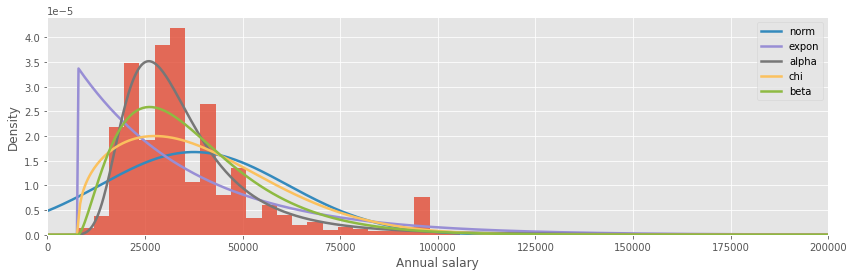

In [15]:
plt.figure(figsize=(14,4))

plt.xlabel('Annual salary')
plt.ylabel('Density')

plt.hist(df_s.average_annual_salary, density=True, bins=150, alpha=0.8)

dist_2 = ["norm", "expon"]
dist_3 = ["alpha", "chi"]
dist_4 = ["beta"]

data = df_s.average_annual_salary

for d in dist_2:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1])

    plt.plot(x, y, lw=2.5, label=d)


for d in dist_3:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1], parameters[2])

    plt.plot(x, y, lw=2.5, label=d)
    
for d in dist_4:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1], parameters[2], parameters[3])

    plt.plot(x, y, lw=2.5, label=d)


plt.xlim(0, 200000)

plt.legend()
plt.show()

Random sampling from the distribution

In [16]:
from scipy.stats import alpha
parameters = alpha.fit(data)
a, n_min, scale = parameters

/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [17]:
df["salary_na_dist"] = df["average_annual_salary"].copy()
n_null = df.salary_na_dist.isna().sum()
df.loc[df.salary_na_dist.isna(), "salary_na_dist"] = alpha.rvs(a, size=n_null) * scale + n_min

### 2. Data augmentation for text

In [18]:
import string
import random

from nltk.tokenize import word_tokenize

In [19]:
sample = df[df.company_description.notnull()].company_description.iloc[0]

- Character augmentation

In [20]:
letters = string.ascii_lowercase

In [21]:
def delete_char(text, n=1):
    for i in range(n):
        l = len(text)
        idx = random.choice(range(l))
        text = text[:idx] + text[idx+1:]
    return text

In [22]:
def insert_char(text, n=1):
    for i in range(n):
        l = len(text)
        w = random.choice(letters)
        idx = random.choice(range(l))
        text = text[:idx] + w + text[idx:]
    return text

In [23]:
def replace_char(text, n=1):
    for i in range(n):
        l = len(text)
        w = random.choice(letters)
        idx = random.choice(range(l))
        text = text[:idx] + w + text[idx+1:]
    return text

- Word augmentaion

In [24]:
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [25]:
def delete_words(text, n=1):
    tokens = word_tokenize(text)
    for i in range(n):
        l = len(tokens)
        idx = random.choice(range(l))
        del tokens[idx]
    return " ".join(tokens)

In [26]:
def swap_words(text):
    tokens = word_tokenize(text)
    l = len(tokens)
    m,n = random.sample(range(l), 2)
    tokens[m], tokens[n] = tokens[n], tokens[m]
    return " ".join(tokens)

replace words with synonyms

In [27]:
stop_words = set(stopwords.words("english"))

In [28]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        synonyms += [w for w in syn.lemma_names() if w != word]
    return list(set(synonyms))

In [29]:
def replace_by_synonyms(text, n=1):
    tokens = word_tokenize(text)
    i = 0
    while i<n:
        l = len(tokens)
        idx = random.choice(range(l))
        w = tokens[idx].lower()
        synonyms = get_synonyms(w)
        if w in stop_words:
            pass
        elif synonyms:
            s = random.choice(synonyms)
            tokens[idx] = s
            i += 1
    return " ".join(tokens)

- Sentence augmentation

In [30]:
def swap_sentences(text):
    tokens = sent_tokenize(text)
    l = len(tokens)
    m,n = random.sample(range(l), 2)
    tokens[m], tokens[n] = tokens[n], tokens[m]
    return " ".join(tokens)

In [31]:
def shuffle_sentences(text):
    tokens = sent_tokenize(text)
    random.shuffle(tokens)
    return " ".join(tokens)

- Hybrid augmentation

use functions

In [32]:
text = shuffle_sentences(sample)
text = replace_by_synonyms(text, n=5)
text = swap_words(text)
text = delete_char(text, n=5)

In [33]:
text

'We are more than just your average ‘ job-network ’ or agency we provide a complete and thorough recruitment proess , our commitment to the jut_out is ensuring you are kept informed at all times , allow a candidate transparent service which allows you , the candidate to be in control of your own next move . Established in 1973 we pride ourselves on our high levels of customer service and interaction . They will endeavour to get to know you and your job run requirements in detail on a very personal level and be open and honorable in relation to their ability to assist with your job search . So whether you ’ re looking for a new role , a career change , fancy a career in recruitment or even if you are unsure we are always happy to talk to candidates that smply might want to discuss their option at a tempo that sits them . Recruiting for both the permanent and temporary / contract markets across the UK but most predominantly within the North West region , our consultants have an energy an

OOP (object-oriented programming)

In [34]:
class ShuffleSentences:
    def augment(self, text):
        tokens = sent_tokenize(text)
        random.shuffle(tokens)
        return " ".join(tokens)

class ReplaceBySynonyms:
    def __init__(self, n):
        self.stop_words = set(stopwords.words("english"))
        self.n = n
    
    def get_synonyms(self, word):
        synonyms = []
        for syn in wordnet.synsets(word):
            synonyms += [w for w in syn.lemma_names() if w != word]
        return list(set(synonyms))
    
    def augment(self, text):
        tokens = word_tokenize(text)
        i = 0
        while i<self.n:
            l = len(tokens)
            idx = random.choice(range(l))
            w = tokens[idx].lower()
            synonyms = self.get_synonyms(w)
            if w in stop_words:
                pass
            elif synonyms:
                s = random.choice(synonyms)
                tokens[idx] = s
                i += 1
        return " ".join(tokens)
    
class SwapWords:
    def augment(self, text):
        tokens = word_tokenize(text)
        l = len(tokens)
        m,n = random.sample(range(l), 2)
        tokens[m], tokens[n] = tokens[n], tokens[m]
        return " ".join(tokens)
    
class DeleteChar:
    def __init__(self, n):
        self.n = n
        
    def augment(self, text):
        for i in range(self.n):
            l = len(text)
            idx = random.choice(range(l))
            text = text[:idx] + text[idx+1:]
        return text

In [35]:
class Compose:
    def __init__(self, augmentors):
        self.augmentors = augmentors.copy()
        
    def __call__(self, x):
        for augmentor in self.augmentors:
            x = augmentor.augment(x)
        return x

In [36]:
shuffle_sentences_obj = ShuffleSentences()
replace_by_synonyms_obj = ReplaceBySynonyms(n=2)
swap_words_obj = SwapWords()
delete_char_obj = DeleteChar(n=2)
Augmentors = Compose([shuffle_sentences_obj, replace_by_synonyms_obj, swap_words_obj, delete_char_obj])

In [37]:
Augmentors(sample)

'GPW Recruitmentare one of the leading recruitment companies in the North West . You ’ re probably wondering what kind of candidate services we offer ? They will eneavour to get to know you and your job hunting requirements in detail on a very personal level and be open and honest in relation to their ability to assist with your job search . Recruiting for both the permanent and temporary / contract markets across the UK but most predominantly within the North western_United_States region , our consultants high an energy and enthusiasm for their work unlike any other recruitment company . So whether you ’ re looking for a new role , a career change , fancy a career in recruitment or even if you are unsure we are always happy to talk to candidates that simply might want to discuss their option at a pace that suits them . We are more than just your average ‘ job-network ’ or agency we provide a complete and thoroughgoing recruitment process , our commitment to the project is ensuring you

### 3. Data augmentation for time series data

Plot the daily crawling jobs

In [38]:
df["crawl_timestamp"] = pd.to_datetime(df["crawl_timestamp"])
ds_time = df.resample(rule='H', on='crawl_timestamp').count()["crawl_timestamp"]
ds_time = ds_time[ds_time.index>'2021-01-01']

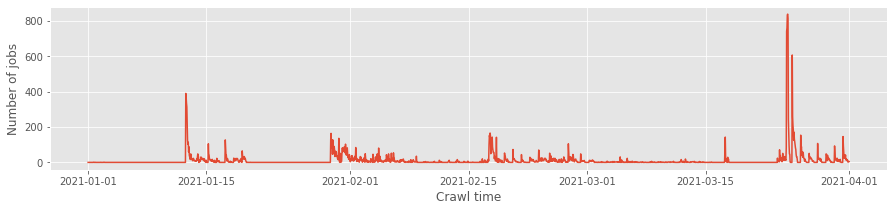

In [39]:
plt.figure(figsize=(15,3))
plt.xlabel('Crawl time')
plt.ylabel('Number of jobs')

plt.plot(ds_time.index, ds_time.values)
plt.show()

- Add noise

In [40]:
def plot_diff(origin, augmented):
    plt.figure(figsize=(15,3))
    plt.xlabel('Crawl time')
    plt.ylabel('Number of jobs')

    plt.plot(ds_time.index, origin, label="origin data")
    plt.plot(ds_time.index, augmented, label="augmented data")
    plt.legend()
    plt.show()

In [41]:
def add_noise(data, noise_factor):
    noise = np.random.randint(low=0, high=noise_factor, size=len(data))
    augmented_data = data + noise
    return augmented_data

In [42]:
augmented_data = add_noise(ds_time.values, noise_factor=100)

In [43]:
class AddNoise:
    def __init__(self, noise_factor):
        self.noise_factor = noise_factor
    def augment(self, data):
        noise = np.random.randint(low=0, high=self.noise_factor, size=len(data))
        augmented_data = data + noise
        return augmented_data

In [44]:
add_noise_obj = AddNoise(noise_factor=100)
augmented_data = add_noise_obj.augment(ds_time.values)

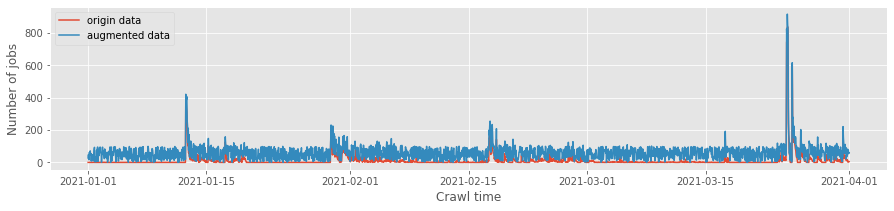

In [45]:
plot_diff(origin=ds_time.values, augmented=augmented_data)

- Shift data

In [46]:
def shift_data(data, time_shift):
    shifted_data = np.roll(data, time_shift)
    return shifted_data

In [47]:
augmented_data = shift_data(ds_time.values, time_shift=50)

In [48]:
class ShiftData:
    def __init__(self, time_shift):
        self.time_shift = time_shift
    def augment(self, data):
        shifted_data = np.roll(data, self.time_shift)
        return shifted_data

In [49]:
shift_data_obj = ShiftData(time_shift=50)
augmented_data = shift_data_obj.augment(ds_time.values)

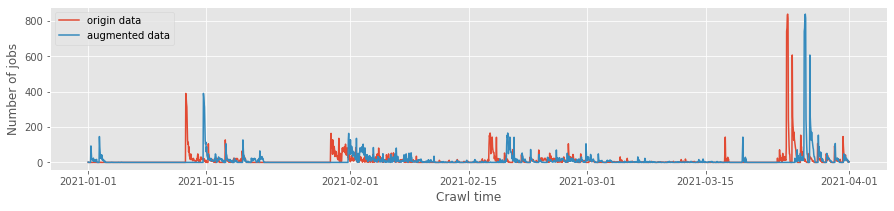

In [50]:
plot_diff(origin=ds_time.values, augmented=augmented_data)

- Clip

In [51]:
def clip(data, max_n_jobs):
    clip_data = np.clip(data, 0, max_n_jobs)
    return clip_data

In [52]:
augmented_data = clip(ds_time.values, max_n_jobs=500)

In [53]:
class Clip():
    def __init__(self, max_n_jobs):
        self.mx = max_n_jobs
    def augment(self, data):
        clip_data = np.clip(data, 0, self.mx)
        return clip_data

In [54]:
clip_obj = Clip(max_n_jobs=500)
augmented_data = clip_obj.augment(ds_time.values)

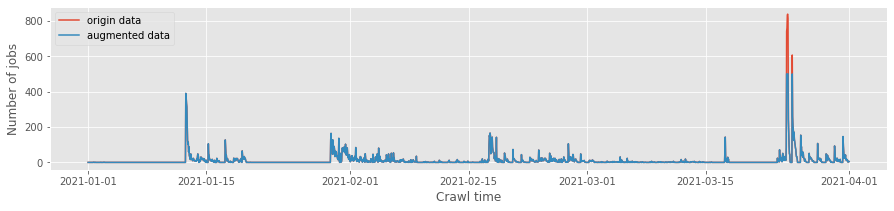

In [55]:
plot_diff(origin=ds_time.values, augmented=augmented_data)

- Remove slices

In [56]:
def remove_slices(data, n_slices, max_time):
    out_data = data.copy()
    S = sorted(np.random.randint(len(data), size=n_slices))
    S.append(len(data))
    E = []
    for i in range(len(S)-1):
        if S[i+1] - S[i] > max_time:
            E.append(random.randint(S[i], S[i]+max_time))
        else:
            E.append(random.randint(S[i], S[i+1]))
    for i,j in zip(S, E):
        out_data[i:j] = 0
    return out_data

In [57]:
augmented_data = remove_slices(ds_time.values, n_slices=5, max_time=500)

In [58]:
class RemoveSlice:
    def __init__(self, n_slices, max_time):
        self.n_slices = n_slices
        self.max_time = max_time

    def augment(self, data):
        out_data = data.copy()
        S = sorted(np.random.randint(len(data), size=self.n_slices))
        S.append(len(data))
        E = []
        for i in range(len(S)-1):
            if S[i+1] - S[i] > self.max_time:
                E.append(random.randint(S[i], S[i]+self.max_time))
            else:
                E.append(random.randint(S[i], S[i+1]))
        for i,j in zip(S, E):
            out_data[i:j] = 0
        return out_data

In [59]:
remove_slices_obj = RemoveSlice(n_slices=5, max_time=500)
augmented_data = remove_slices_obj.augment(ds_time.values)

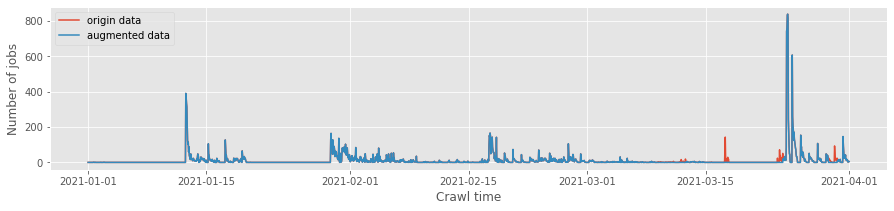

In [60]:
plot_diff(origin=ds_time.values, augmented=augmented_data)

- combinations

In [61]:
def compose(data):
    augmented_data = add_noise(data, noise_factor=100)
    augmented_data = shift_data(augmented_data, time_shift=50)
    augmented_data = clip(augmented_data, max_n_jobs=500)
    augmented_data = remove_slices(augmented_data, n_slices=5, max_time=500)
    return augmented_data

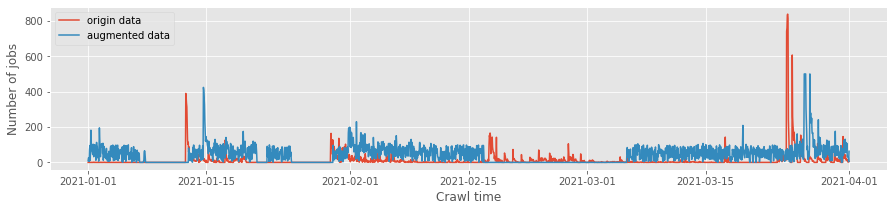

In [62]:
augmented_data = compose(ds_time.values)
plot_diff(origin=ds_time.values, augmented=augmented_data)

In [63]:
class Compose:
    def __init__(self, augmentors):
        self.augmentors = augmentors.copy()
        
    def __call__(self, x):
        for augmentor in self.augmentors:
            x = augmentor.augment(x)
        return x

In [64]:
add_noise_obj = AddNoise(noise_factor=100)
shift_data_obj = ShiftData(time_shift=50)
clip_obj = Clip(max_n_jobs=500)
remove_slices_obj = RemoveSlice(n_slices=5, max_time=500)

Augmentors = Compose([add_noise_obj, shift_data_obj, clip_obj, remove_slices_obj])
augmented_data = Augmentors(ds_time.values)

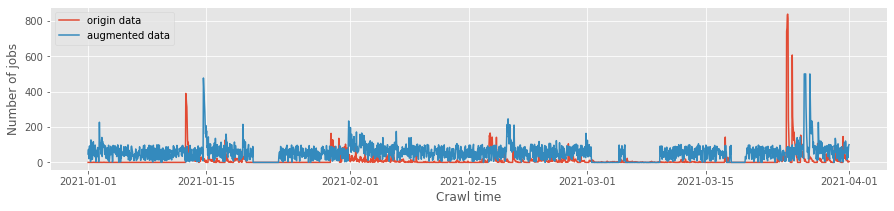

In [65]:
plot_diff(origin=ds_time.values, augmented=augmented_data)

$\color{white}{\text{PLEASE SUBMIT YOUR OWN SOLUTIONS}}$